In [1]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install lightgbm
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 106.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.5/503.5 kB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 89.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 113.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 135.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 9.6 MB/s eta 0:00:00
 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor


In [4]:
test =  pd.read_csv('../data/raw/bike_sharing_test.csv') #hago el eda en este
df_raw = pd.read_csv('../data/raw/bike_sharing_train.csv')


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
df_raw.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
4543,2011-11-02 09:00:00,4,0,1,1,13.94,18.180,87,0.0000,15,213,228
2073,2011-05-13 07:00:00,2,0,1,3,20.50,24.240,88,11.0014,16,141,157
829,2011-02-18 00:00:00,1,0,1,1,18.04,21.970,72,19.0012,12,20,32
9778,2012-10-11 19:00:00,4,0,1,1,18.04,21.970,51,8.9981,81,662,743
7116,2012-04-14 21:00:00,2,0,0,2,22.96,26.515,43,8.9981,53,167,220
7745,2012-06-03 02:00:00,2,0,0,1,21.32,25.000,59,7.0015,22,67,89
64,2011-01-03 19:00:00,1,0,1,1,8.20,12.880,47,0.0000,8,102,110
2410,2011-06-08 08:00:00,2,0,1,1,31.16,35.605,58,11.0014,46,435,481
5451,2012-01-02 06:00:00,1,1,0,1,10.66,11.365,41,26.0027,0,14,14
4998,2011-12-02 08:00:00,4,0,1,1,9.84,14.395,87,0.0000,13,432,445


In [10]:
#df_raw no se toca, hacemos una copia, vamos a limpiar las variables tipo objeto
df_interim = df_raw.copy()

#hago las transformaciones

In [11]:
df_interim['datetime']=pd.to_datetime(df_interim['datetime'])
#como es serie de tiempo,... escuchar la repeticion dijo algo importante, hay indicadores del eje comun el index
#quiero q la fecha sea indice
df_interim = df_interim.set_index(df_interim['datetime'])
df_interim['hour'] = df_interim.index.hour
df_interim['day'] = df_interim.index.day
df_interim['month'] = df_interim.index.month
df_interim = df_interim.drop(['datetime','casual','registered'], axis=1)

#negocio de compartir bicicletas, lo de alquiler de bicis en la calle

In [12]:
df_interim.sample(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-05-05 12:00:00,2,0,1,1,21.32,25.000,34,23.9994,196,12,5,5
2012-06-01 09:00:00,2,0,1,2,26.24,28.790,83,15.0013,298,9,1,6
2012-02-05 04:00:00,1,0,0,2,9.84,12.120,87,8.9981,9,4,5,2
2012-08-08 11:00:00,3,0,1,2,32.80,37.120,52,0.0000,239,11,8,8
2012-01-05 02:00:00,1,0,1,1,8.20,11.365,51,6.0032,4,2,5,1
2012-05-15 06:00:00,2,0,1,3,22.96,26.515,94,15.0013,24,6,15,5
2012-11-15 01:00:00,4,0,1,2,10.66,13.635,65,7.0015,16,1,15,11
2012-01-16 18:00:00,1,1,0,1,10.66,11.365,52,22.0028,181,18,16,1
2011-02-02 05:00:00,1,0,1,3,9.02,12.120,93,7.0015,3,5,2,2


In [13]:
df = df_interim.copy()

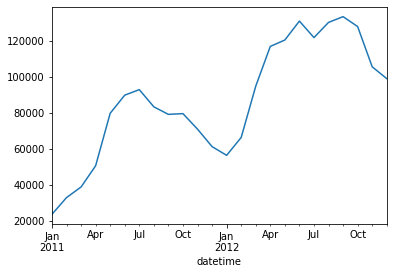

In [14]:
#ahora vamos con la serie de tiempo!
df['count'].resample('M').sum().plot() #hago una agregacion con tiempo de por medio, por MES, por ej
plt.show()


#aca comienza la lectura empresarial !los datos estan del 2011, vemos una subida de operaciones. este grafico se da al gte de operaciones.
esto por mes me esta diciendo como crece el negocio

In [15]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,11.541613,9.992559,6.521495
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,6.915838,5.476608,3.444373
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,6.000000,5.000000,4.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,12.000000,10.000000,7.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,18.000000,15.000000,10.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,23.000000,19.000000,12.000000


array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

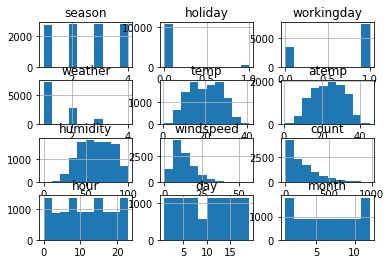

In [16]:
df.hist()

In [17]:
df #vemos el detalle de la serie de tiempo, la unidad minima de este indice es la hora 

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [20]:
#graficas de , lo q vimos en las graficas del teorico
res = seasonal_decompose(df['count'].values,period=24)
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

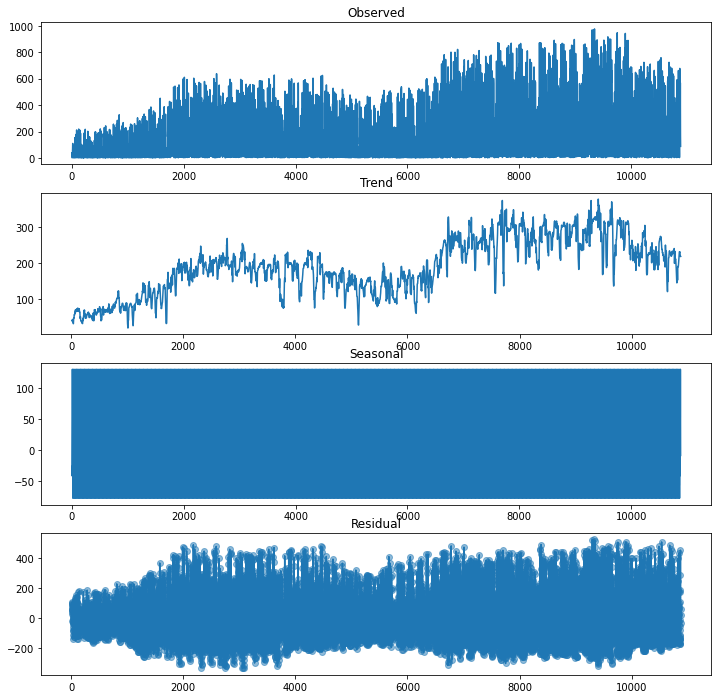

In [22]:
fig,ax=plt.subplots(4, figsize=(12,12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual,x=range(len(res_residual)),alpha=0.5)

plt.show()

In [23]:
res = seasonal_decompose(df['count'].values[-250:],period=24) #le pongo un rango, escuhar esta parte q no se entendio
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

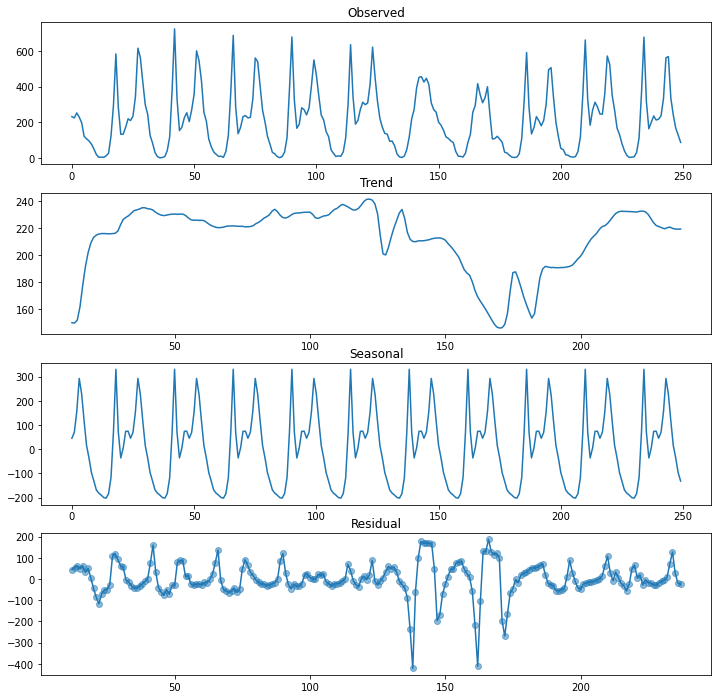

In [24]:
fig,ax=plt.subplots(4, figsize=(12,12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual,x=range(len(res_residual)),alpha=0.5)

plt.show()
#graficas de descomposicion

si fuera a pronosticar debo pronosticar con marcos pequeños de tiempo entre 40 , 50, 30 dias
como trend sube y baja no me aporta si es muy largo el periodo
el eje del tiempo esta pesente, eleigmos 250 periodos de un dia, todo el eje x representa el tiempo pero la descomposicion esta echa en base a las cuentas a la fila count
esta vista es de maching learning, no es para vista de gente comun tipo marketing
esto no sirve para una descripcion analitica, la intencion de este proceso es para machine learning no analisis
es para otro tipo de publico


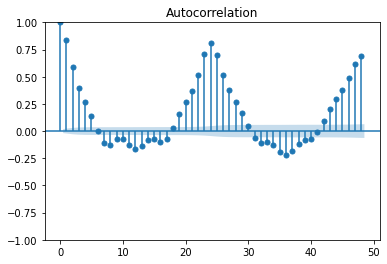

In [25]:
plot_acf(df['count'].values, lags=48) #count es el objetivo
plt.show()

aca me dice retrocediendo 48 bloques de una hora atras, en el primer punto si me autocorrelciono conmigo (de person) es 1
esto esta altamente correlacioando porq esta cerca mio

In [29]:
#vamos a pronosticar lo q hemos aprendido de la ... esto es el alogritomo de validacion , lo tuneo hasta llegar a lo q quiero, y luego lo aplico en el file de test
#con el file de test no se puede tunear, se hace todo en train, ese train lo cortamos tambien para aprendizaje

X = df.drop('count',axis=1) #elimino la var objetivo para analizar y realizar los algoritmos, axis es el eje de las x
y = df['count']#voy a estimar
#le digo q horizonte quiero, no es prudente pronosticar 1 o 2 meses, vemos la grafica train q es muy irrecular, muchos ciclos, es irregular, por lo q hago pronosticos de pocos dias
#pronostico por ej 7 dias, la grafica me dice usa periodos cortos
horizon = 168 #(24*7 , 24 horas por 7 dias, nuestro minimo era 1 hora)

#separo los dos bloques
X_train, X_test = X.iloc[:-horizon,:],X.iloc[-horizon:,:] #con iloc selecciono un bloque, quiero todos los puntos menos horizon, desde el punto 0 al punto n-168, el otro : es todas las colm , luego el otro iloc es el rango de horizon, los 168 ultimos 

#esto es una sola col, la q voy a pronosticar, es count, este ultimo pedazo lo uso para validar, y.iloc[-horizon:]
y_train, y_test = y.iloc[:-horizon],y.iloc[-horizon:] 


In [30]:
model = LGBMRegressor(random_state=123)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [31]:
mae = np.round(mean_absolute_error(y_test,y_pred),1) #vamos a proosticar el uso de las bicicletas, por eso redonde
rmse = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),1)

print(f'MAE : {mae},RMSE : {rmse}')

MAE : 53.8,RMSE : 73.8


MAE : 53.8,RMSE : 73.8
si quiero pronosticar el uso de estas bicis yo me equivocario en promedio con 53 bicis,cuando hice el resample me dio mas de 120.000, mirar la grafica, asi q si le erro por 53 no es nada, puedo usar esto, tener 50 de dif no es malo, si me da por ej 1000 si es malo
el RMSE es mas acido porq lo eleva al cuadrado, las dieferencias grandes las castiga mas, y me da 73 es manejable, con 100 mil al mes esta bien

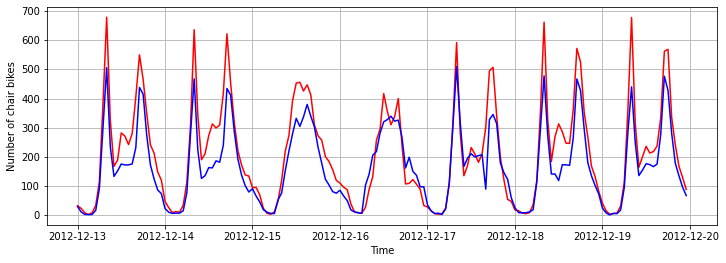

In [32]:
fig=plt.figure(figsize=(12,4))
plt.plot(y_test,color='Red')
plt.plot(pd.Series(y_pred,index=y_test.index),color='Blue') #lo paso a serie porq debe estar como numpay
plt.xlabel('Time')
plt.ylabel('Number of chair bikes') #cantidad de bicis compartidas
plt.grid()
plt.show()


#el y_test es el ultimo tiempo, los ultimo 168 puntos, lo real es lo rojo, mi pronostico es el azul, asi q casi le acerto, anduvo bastente bien
# lo podemos tunear para q conicida mas

In [34]:
df_var_imp = pd.DataFrame({'var':model.feature_name_,'imp':model.feature_importances_}).sort_values(by='imp',ascending=False) #hago mi diccionario
df_var_imp

,var,imp
8,hour,752
9,day,401
6,humidity,392
4,temp,323
2,workingday,253
10,month,226
5,atemp,222
7,windspeed,190
0,season,102
3,weather,87


la var mas importante es la hora y el dia, son super claves para el pronstico de las bicis
la humedad tambien me dice si tengo gans de usar la bici o no es un buen predictor
la otra var q afecta al modelo es la temperatura, es una var altamente predictora
esto lo podemos tunear


In [35]:
df['count_lag_week'] = df['count'].shift(24*7) #lag: diferencia de tiempo, muevo una semana para pronosticar, 24 horas por 7 dias
df=df.dropna(how='any',axis=0) #saco los na de la prmer semana

MAE : 32.7,RMSE : 48.4


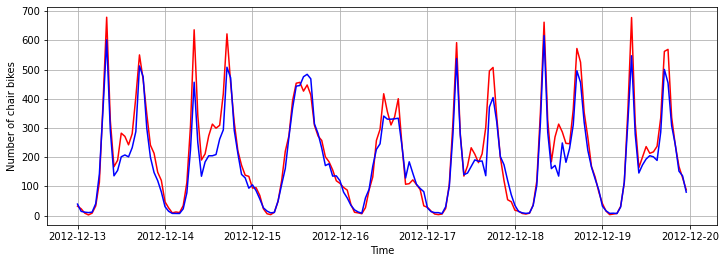

In [36]:
X = df.drop('count',axis=1) #elimino la var objetivo para analizar y realizar los algoritmos, axis es el eje de las x
y = df['count']#voy a estimar
#le digo q horizonte quiero, no es prudente pronosticar 1 o 2 meses, vemos la grafica train q es muy irrecular, muchos ciclos, es irregular, por lo q hago pronosticos de pocos dias
#pronostico por ej 7 dias, la grafica me dice usa periodos cortos
horizon = 168 #(24*7 , 24 horas por 7 dias, nuestro minimo era 1 hora)

#separo los dos bloques
X_train, X_test = X.iloc[:-horizon,:],X.iloc[-horizon:,:] #con iloc selecciono un bloque, quiero todos los puntos menos horizon, desde el punto 0 al punto n-168, el otro : es todas las colm , luego el otro iloc es el rango de horizon, los 168 ultimos 

#esto es una sola col, la q voy a pronosticar, es count, este 
# 
# ultimo pedazo lo uso para validar, y.iloc[-horizon:]
y_train, y_test = y.iloc[:-horizon],y.iloc[-horizon:] 

model = LGBMRegressor(random_state=123)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test,y_pred),1) #vamos a proosticar el uso de las bicicletas, por eso redonde
rmse = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),1)

print(f'MAE : {mae},RMSE : {rmse}')

fig=plt.figure(figsize=(12,4))
plt.plot(y_test,color='Red')
plt.plot(pd.Series(y_pred,index=y_test.index),color='Blue') #lo paso a serie porq debe estar como numpay
plt.xlabel('Time')
plt.ylabel('Number of chair bikes') #cantidad de bicis compartidas
plt.grid()
plt.show()

mejoramos la prediccion a 32 bicis!
el msre salio 48 vs 73, mejoro pila
esta vez capturo mejor el sabado y domingo, seria 15 y 16
me muestra q me tendria q cubrir para los viernes, para q de mas pareja, igual da una buena prediccion


In [37]:
df_var_imp = pd.DataFrame({'var':model.feature_name_,'imp':model.feature_importances_}).sort_values(by='imp',ascending=False) #hago mi diccionario
df_var_imp

#var de importancia a ver como le fue ahora, ahora me da q esta nueva var es la segunda mejor, count_lag_week

,var,imp
8,hour,703
11,count_lag_week,506
9,day,347
6,humidity,309
4,temp,296
2,workingday,237
5,atemp,170
10,month,154
7,windspeed,120
3,weather,70


In [40]:
df['count_lag_month'] = df['count'].shift(24*7*30) #lag: diferencia de tiempo, muevo una semana para pronosticar, 24 horas por 7 dias por 30 dias
df=df.dropna(how='any',axis=0)

/tmp/ipykernel_2521/4016814256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count_lag_month'] = df['count'].shift(24*7*30) #lag: diferencia de tiempo, muevo una semana para pronosticar, 24 horas por 7 dias por 30 dias


MAE : 33.8,RMSE : 47.6


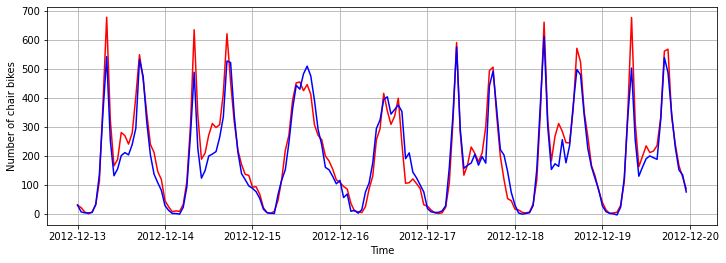

In [41]:
X = df.drop('count',axis=1) #elimino la var objetivo para analizar y realizar los algoritmos, axis es el eje de las x
y = df['count']#voy a estimar
#le digo q horizonte quiero, no es prudente pronosticar 1 o 2 meses, vemos la grafica train q es muy irrecular, muchos ciclos, es irregular, por lo q hago pronosticos de pocos dias
#pronostico por ej 7 dias, la grafica me dice usa periodos cortos
horizon = 168 #(24*7 , 24 horas por 7 dias, nuestro minimo era 1 hora)

#separo los dos bloques
X_train, X_test = X.iloc[:-horizon,:],X.iloc[-horizon:,:] #con iloc selecciono un bloque, quiero todos los puntos menos horizon, desde el punto 0 al punto n-168, el otro : es todas las colm , luego el otro iloc es el rango de horizon, los 168 ultimos 

#esto es una sola col, la q voy a pronosticar, es count, este 
# 
# ultimo pedazo lo uso para validar, y.iloc[-horizon:]
y_train, y_test = y.iloc[:-horizon],y.iloc[-horizon:] 

model = LGBMRegressor(random_state=123)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test,y_pred),1) #vamos a proosticar el uso de las bicicletas, por eso redonde
rmse = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),1)

print(f'MAE : {mae},RMSE : {rmse}')

fig=plt.figure(figsize=(12,4))
plt.plot(y_test,color='Red')
plt.plot(pd.Series(y_pred,index=y_test.index),color='Blue') #lo paso a serie porq debe estar como numpay
plt.xlabel('Time')
plt.ylabel('Number of chair bikes') #cantidad de bicis compartidas
plt.grid()
plt.show()

In [42]:
df_var_imp = pd.DataFrame({'var':model.feature_name_,'imp':model.feature_importances_}).sort_values(by='imp',ascending=False) #hago mi diccionario
df_var_imp

,var,imp
8,hour,704
11,count_lag_week,515
9,day,283
4,temp,258
2,workingday,244
6,humidity,243
12,count_lag_month,216
5,atemp,147
10,month,140
3,weather,87


count_lag_month no es un buen predictor !

tambien puedo usar otro regresro, hacer lo mismo con RandomForest a ver como nos va.